# Notebook to investigate Dense Network [Last Mass]

In [20]:
# imports
from random import randint
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
from tqdm import trange
# import my_dataset
import matplotlib.pyplot as plt
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [2]:
from sfh.datasets.tng100 import tng100
dset = tfds.load('tng100', split='train', data_dir=data_dir)

In [3]:
for example in dset.take(1):
    print(example.keys())

dict_keys(['Mstar', 'Mstar_Half', 'SFR_Max', 'SFR_Rad', 'SFR_halfRad', 'last_major_merger', 'last_over_max', 'mass_quantiles', 'noiseless_griz', 'object_id', 'sed', 'stellar_light', 'time', 'velocity_dispersion_map', 'velocity_map'])


Populating the interactive namespace from numpy and matplotlib


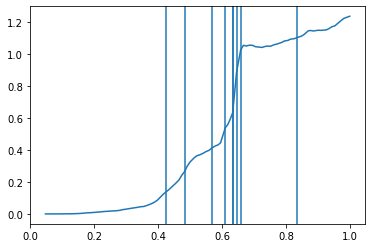

In [5]:
%pylab inline
plot(example['time'], example['Mstar'])
for i in example['mass_quantiles']:
    axvline(i)

In [8]:
# functions

def Model(nb_summaries):
    """ Creates a small fully connected network
    """
    return tf.keras.Sequential([
        tfkl.Input(shape=(143)),
        tfkl.Dense(8, activation='relu'),
        tfkl.Dense(16, activation='relu'),
        tfkl.Dense(32, activation='relu'),
        tfkl.Dense(64, activation='relu'),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(256, activation='relu'),
        tfkl.Dense(512, activation='relu'),
        tfkl.Dense(nb_summaries, activation='softplus')
        ])

def to_mag(x):
    return (-2.5*tf.math.log(x)+8.90)

def preprocessing(example):
#     def conv(x):
    example['flux'] = to_mag(example['flux'])
    example['flux'] = example['flux']/46.
    return example['flux'], example['mass'][0]

def preprocessing_test(example):
#     def conv(x):
    example['flux'] = to_mag(example['flux'])
    example['flux'] = example['flux']/46.
    #example = example[np.where(example['mass']>0.5)]
    return example['flux'], example['mass'][0], example['mass'], example['time'], example['quantile']

#     img = tf.math.asinh(example['image'] / tf.constant(scaling) / 3. )
#   # We return the image as our input and output for a generative model
#   return img

def input_fn(mode='train', batch_size=32):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load('sfhsed', split='train[:80%]', data_dir=data_dir)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.filter(lambda x: x['has_sfh'] == True) # adding a filtering condition to exclude empty catalogs
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
        dataset = dataset.map(preprocessing) # Apply data preprocessing
    else:
        dataset = tfds.load('sfhsed', split='train[20%:]', data_dir=data_dir)
        dataset = dataset.filter(lambda x: x['has_sfh'] == True) # adding a filtering condition to exclude empty catalogs
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
        dataset = dataset.map(preprocessing_test) # Apply data preprocessing
    
    dataset = dataset.batch(batch_size, drop_remainder=True)

    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [9]:
dset = input_fn()

In [19]:
model = Model(1)
# print(model.summary)
# dset = input_fn()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MSE, metrics=['accuracy'])

EPOCHS = 200
now = str(datetime.datetime.now())[0:16].replace('-','_').replace(' ','_').replace(':','_')
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/'+label+'/'+now
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)
# The model weights (that are considered the best) are loaded into the model.

NameError: name 'label' is not defined

In [43]:
history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/200
200/200 [==============================] - ETA: 2:02 - loss: 4.3550 - accuracy: 0.0000e+ - ETA: 0s - loss: 4.1108 - accuracy: 0.0000e+00 - ETA: 0s - loss: 2.9895 - accuracy: 0.0000e+ - ETA: 0s - loss: 2.3560 - accuracy: 0.0000e+ - ETA: 0s - loss: 1.8599 - accuracy: 0.0000e+ - ETA: 0s - loss: 1.8301 - accuracy: 0.0000e+ - ETA: 0s - loss: 1.9890 - accuracy: 0.0000e+ - ETA: 0s - loss: 2.2095 - accuracy: 0.0000e+ - 1s 2ms/step - loss: 2.2142 - accuracy: 0.0000e+00
Epoch 2/200
200/200 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.0000e+ - ETA: 0s - loss: 11.0413 - accuracy: 0.0000e+0 - ETA: 0s - loss: 8.0035 - accuracy: 0.0000e+0 - ETA: 0s - loss: 5.7380 - accuracy: 0.0000e+ - ETA: 0s - loss: 4.9744 - accuracy: 0.0000e+ - ETA: 0s - loss: 4.5138 - accuracy: 0.0000e+ - ETA: 0s - loss: 4.0984 - accuracy: 0.0000e+ - ETA: 0s - loss: 3.7839 - accuracy: 0.0000e+ - 0s 2ms/step - loss: 3.6787 - accuracy: 0.0000e+00
Epoch 3/200
200/200 [==========================

In [12]:
checkpoint_filepath = '/gpfsdswork/projects/rech/qrc/uzu97zj/AstroInfo2021/tmp/tmp'
#checkpoint_filepath = '/gpfsdswork/projects/rech/qrc/uzu97zj/AstroInfo2021/tmp/tmp'
model.load_weights(checkpoint_filepath)
#history = model.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
# plt.plot(history.loss)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 1152      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1

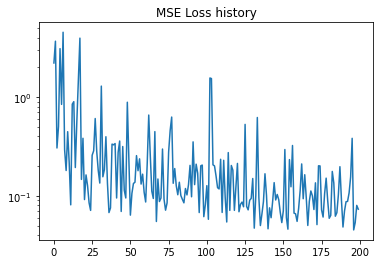

In [48]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(len(model.history.history['loss'])), model.history.history['loss'])
plt.yscale('log')
plt.title('MSE Loss history')
plt.show()

testing loss

In [14]:
dset_test = input_fn(mode='test', batch_size=128)

In [15]:
i = 0
# truthes = []
# predicted = 
for batch, features in enumerate(dset_test):
#     print(features[0].shape)
    if batch > 1:
         break
#     print(batch)
#     print(i)
    predict = model.predict(features[0])
    i = i + 1

In [25]:
# k = 0
# fig, ax = plt.subplots(6, 1, figsize=(5, 10))
# for batch, features in enumerate(dset_test):
#     if batch > 1:
#         break
#     predict = model.predict(features[0])
#     for j, gal in enumerate(features):
#         if j >6:
#             break
# #         ax[k, 0].plot(np.arange(len(features[0][0])), features[0][0])
#         ax[k].plot(features[3][0], features[2][0])
        
#         ax[k].scatter(1, predict[j], marker='x', color='red', s=10)
#         k += 1
#         #ax[k,1].set_ylim(0,1.5)
                  

In [30]:
features.shape

AttributeError: 'tuple' object has no attribute 'shape'

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-gpu-2.6.0/bin/xpython:5: RuntimeWarning: divide by zero encountered in log10


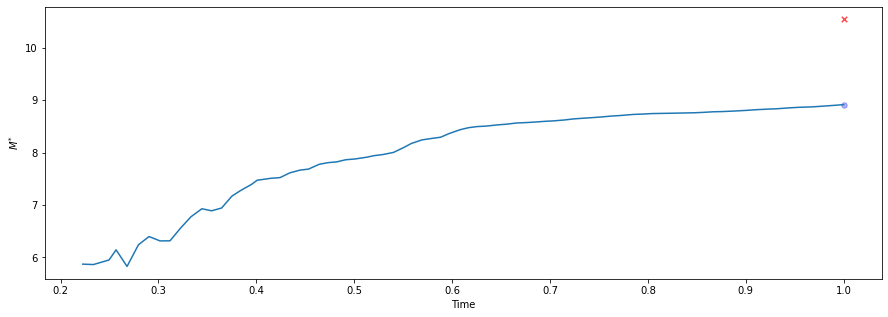

In [18]:
k = randint(0, len(features[0]))
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# features = np.ma.masked_values(features[2],0)
ax.plot(features[3][k], np.log10(features[2][k])+10)
#np.log10(features[2][k])+10
predict[k] = np.ma.masked_values(predict[k],0)
ax.scatter(1, np.log10(predict[k])+10, marker='x', color='red', s=30, alpha=0.7)
ax.scatter(1, np.log10(features[2][k][0])+10, marker='o', color='blue', s=30, alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('$M^{*}$');
plt.show()

In [56]:
err = []
m_m = []
err_n = []
#features = np.ma.masked_values(features[2],0)
#predict[k] = np.ma.masked_values(predict[k],0)
for row in np.arange(len(features[0])):
    error = (features[2][row][0].numpy() - predict[row][0])
    m_max = features[2][row][0].numpy()
    if features[2][row][0].numpy() != 0:
        error_n = (features[2][row][0].numpy() - predict[row][0])/features[2][row][0].numpy()
    err.append(error)
    err_n.append(error_n)
    m_m.append(m_m)

Text(0.5, 0, '$M_{data} - M_{predicted}$')

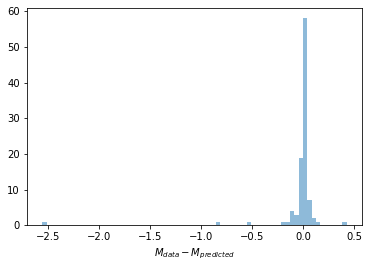

In [22]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err, bins=70, alpha=0.5);
plt.xlabel(r'$M_{data} - M_{predicted}$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

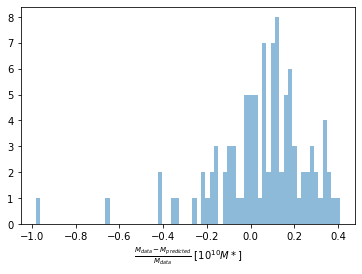

In [26]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

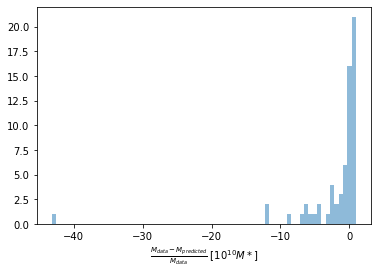

In [37]:
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')
#err

Text(0.5, 0, '$\\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$')

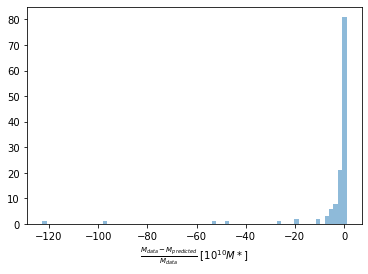

In [60]:
%matplotlib inline
err = np.ma.masked_values(err,0)
err = np.ma.masked_values(err,np.inf)
plt.hist(err_n, bins=70, alpha=0.5);
plt.xlabel(r'$\frac{M_{data} - M_{predicted}}{M_{data}}~[10^{10} M*]$');
#err

In [64]:
np.quantile(err_n,0.68)

0.454129558801651